## S&P Stocks Analysis 

A basic analysis of FY 2023 (Jan-Dec in USA) stock market data of the S&P 100 companies - looking at the price trends, sectoral performance and ownership structure. The data is pulled from Yahoo Finance and Wikipedia (for information on S&P 100 companies). 

In [504]:
import yfinance
import requests 
from bs4 import BeautifulSoup

import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

### Load Stocks Data

In [505]:
# get list of s&p 100 companies for analysis
sp100_page = "https://en.wikipedia.org/wiki/S%26P_100"
page = requests.get(sp100_page)
print(page.status_code)
soup = BeautifulSoup(page.content, 'html.parser')
sp_table = soup.find('table', {'class' :"wikitable", 'id' :'constituents'})
df = pd.read_html(str(sp_table))[0]
sp_tkrs = df.Symbol.values.tolist()

200


/var/folders/yd/c6pqg7cn1zg9lxy5vkyf64fm0000gn/T/ipykernel_70228/3192364838.py:7: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [506]:
# lets fetch stocks data for all S&P 100 companies  
stk_hist, stk_ownd = dict(), dict() 

# setting start and end date for 2023 to analyze stock prices 
st_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 12, 31)

for tick_ in df.Symbol:    
    tkr_conn = yfinance.Ticker(tick_)

    # get stock price history for 2023
    stk_hist[tick_] = tkr_conn.history(start = st_date, end = end_date).reset_index()

    # get list of institutional shareholders for each stock 
    try:
        stk_ownd[tick_] = tkr_conn.institutional_holders
    except:
        print("Couldn't retrieve institutional holders for {}.".format(tick_))
        pass

    # above df provides data point for daily stock performance - lets extract relevant data from timestamp 
    stk_hist[tick_]['Year'] = pd.DatetimeIndex(stk_hist[tick_]['Date']).year
    stk_hist[tick_]['Month'] = pd.DatetimeIndex(stk_hist[tick_]['Date']).month
    stk_hist[tick_]['Day'] = pd.DatetimeIndex(stk_hist[tick_]['Date']).day

BRK.B: No timezone found, symbol may be delisted


Couldn't retrieve institutional holders for BRK.B.


### Stock Performance Analysis 

In [507]:
sctrs = df.Sector.unique().tolist()
# lets start with a simple analysis of Apple's performance - company with highest market cap globally 
df_apl = stk_hist['AAPL']

apl_mnth = df_apl.groupby(['Month'])[['Close','High','Volume']].agg('mean').round(2).reset_index()

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



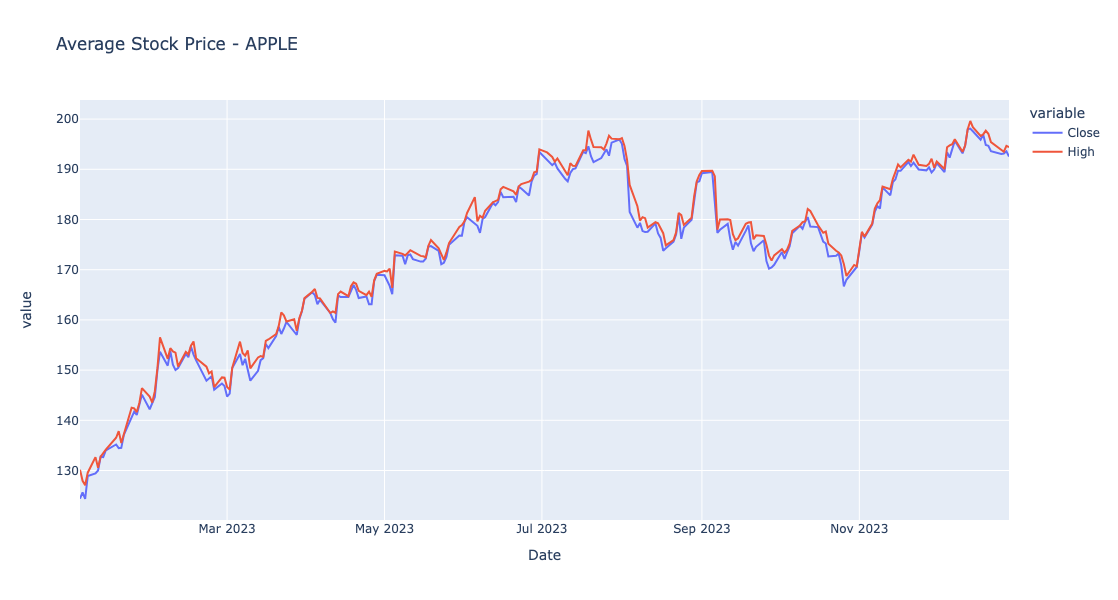

In [508]:
# set up plotly figure
fig = px.line(df_apl, x = 'Date', y = ['Close','High'], title='Average Stock Price - APPLE' , width=1000, height=600)
fig.show()

In [509]:
# lets analyze the other tech companies in S&P 100
sctrs_lst = df.Sector.unique().tolist()
print("List of Sectors listd in S&P:\n{}\n\n".format(sctrs_lst))

# print("List of tech stocks with their ticker information:")
# dict(df[df.Sector == 'Information Technology'][['Symbol', 'Name']].values)

List of Sectors listd in S&P:
['Information Technology', 'Health Care', 'Financials', 'Real Estate', 'Consumer Discretionary', 'Industrials', 'Communication Services', 'Consumer Staples', 'Energy', 'Materials', 'Utilities']


List of tech stocks with their ticker information:


/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



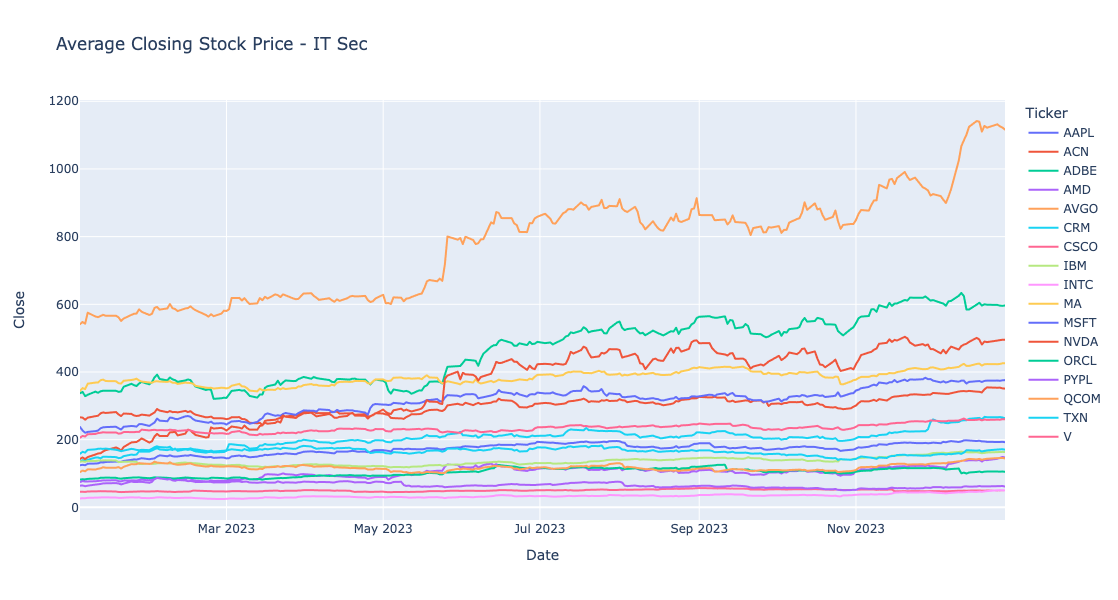

In [510]:
# concat all the tech stock information in single dataframe 
tech_tkrs = df[df.Sector == 'Information Technology'].Symbol.values.tolist()
df_tech = pd.DataFrame()
for tkr_ in tech_tkrs: 
    stk_hist[tkr_]['Ticker'] = tkr_
    df_tech = df_tech._append(stk_hist[tkr_])

# plot the closing price of all tech stocks over the year 
fig = px.line(df_tech, x = 'Date', y = 'Close', title='Average Closing Stock Price - IT Sec' , color='Ticker', width=800, height=600)
fig.show()

In [511]:
sctr_map = dict(df[['Symbol', 'Sector']].values)
stk_hist_all = pd.DataFrame() 
for k_ in stk_hist.keys():
    try:
        df = stk_hist[k_] 
        df['Ticker'] = k_
        df['Sector'] = df['Ticker'].map(sctr_map)
        stk_hist_all = stk_hist_all._append(df)
    except:
        print("Couldn't concat data for {}.".format(k_))
        pass

/var/folders/yd/c6pqg7cn1zg9lxy5vkyf64fm0000gn/T/ipykernel_70228/108266586.py:8: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



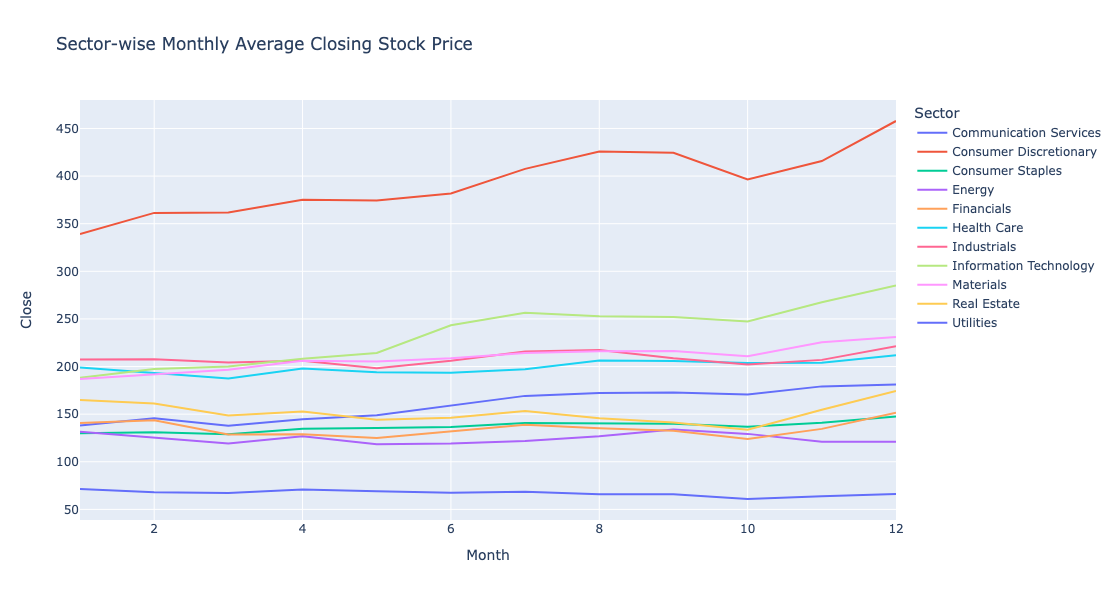

In [512]:
hist_mnth_ave = stk_hist_all.groupby(['Sector','Month'])['Close'].agg('mean').reset_index()
# plot the monthly average closing price of all stocks 
fig = px.line(hist_mnth_ave, x = 'Month', y = 'Close', title='Sector-wise Monthly Average Closing Stock Price' , color='Sector', width=1100, height=600)
fig.show()

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



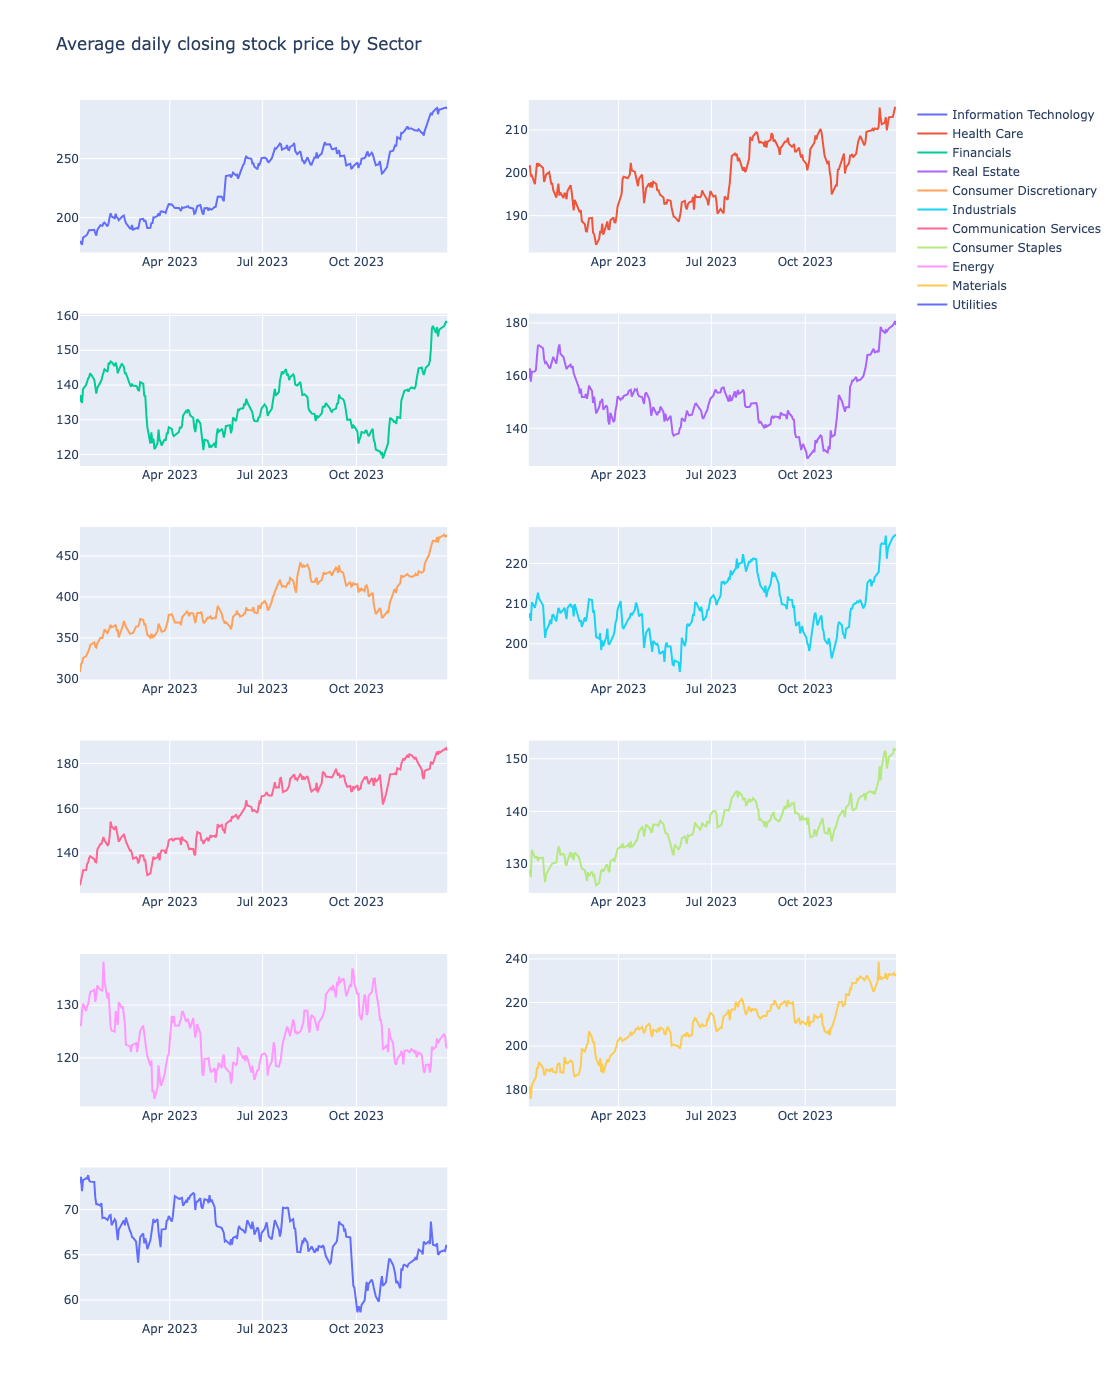

In [672]:
# plot average daily stock price trend for each sector

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=6, cols=2)
subplot_coords = [(1,1), (1,2), (2,1), (2,2), (3,1), (3,2), (4,1) , (4,2), (5,1), (5,2) , (6,1), (6,2)]    

stk_hist_all_ave = stk_hist_all.groupby(['Sector','Date'])['Close'].agg('mean').reset_index()

for sctr,coords in zip(sctrs_lst,subplot_coords):
    stk_sec = stk_hist_all_ave[stk_hist_all_ave.Sector == sctr]
    fig.add_trace(
        go.Scatter(x= stk_sec['Date'], y=stk_sec['Close'], name= sctr),
        row=coords[0], col= coords[1],     
    )
fig.update_layout(height=1400, width=1110, title_text="Average daily closing stock price by Sector")
fig.show()

In [712]:
tot_stk_vols = stk_hist_all.groupby(['Ticker'])['Volume'].agg('sum').to_frame().reset_index()
tot_stk_vols['pct_Volume'] = (tot_stk_vols.Volume/tot_stk_vols.Volume.sum())*100
tot_stk_vols.sort_values(by = 'pct_Volume', ascending = False, inplace = True)
tot_stk_vols['cum_sum'] = tot_stk_vols['pct_Volume'].cumsum()
tot_stk_vols.reset_index(drop = True, inplace = True)

# 25 companies represent 70% of trading volume - label rest of companies as 'others'
other_cos = tot_stk_vols.iloc[25:,:].Ticker.values.tolist()
tot_stk_vols['Ticker'] = tot_stk_vols['Ticker'].mask(tot_stk_vols['Ticker'].isin(other_cos) ,'Others')

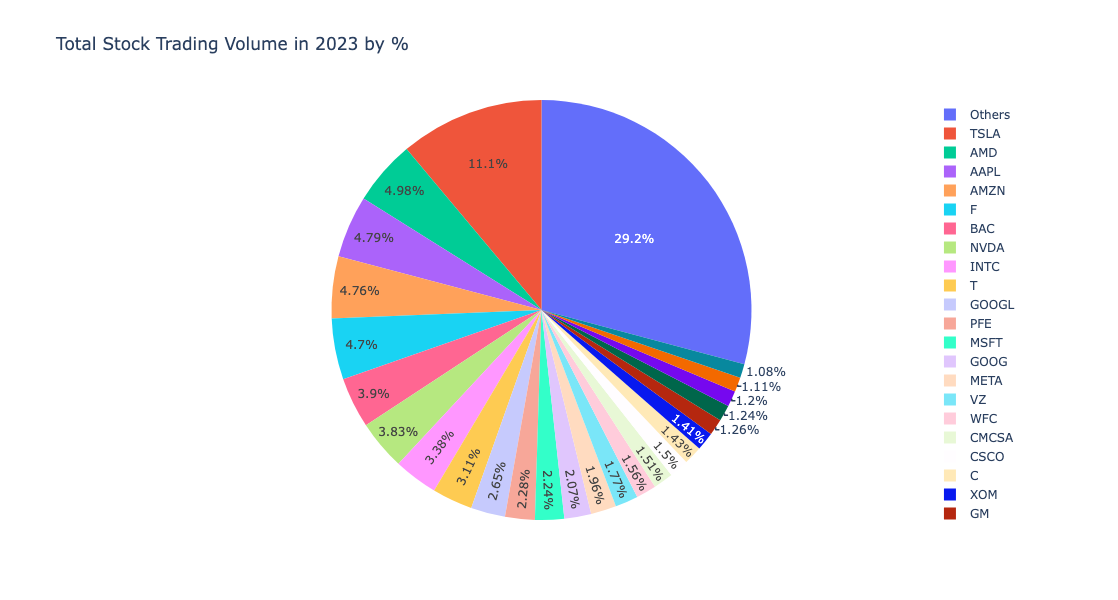

In [717]:
fig = px.pie(
            tot_stk_vols, values='Volume', names='Ticker', 
            title='Total Stock Trading Volume in 2023 by %', 
            height = 600, width = 1000
            )
fig.show()

In [395]:
stk_ownd_all = pd.DataFrame()
df_tech = pd.DataFrame()
for tkr_ in df.Symbol:
    try:
        stk_ownd[tkr_]['Ticker'] = tkr_
        stk_ownd_all = stk_ownd_all._append(stk_ownd[tkr_])
    except: 
        print("No data to append for {}.".format(tkr_))
        

No data to append for BRK.B.


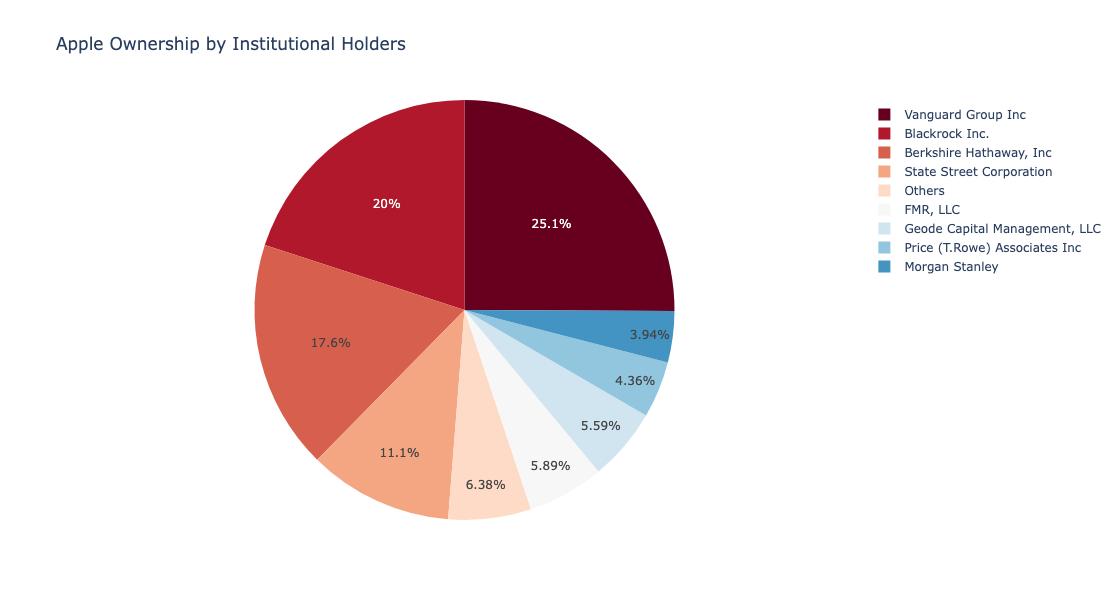

In [411]:
aapl_own = stk_ownd_all[stk_ownd_all.Ticker == 'AAPL']
fig = px.pie(
            aapl_own, values='pctHeld', names='Holder', 
            title='Apple Ownership by Institutional Holders', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            height = 600
            )
fig.show()

In [396]:
##### stk_ownd_vals = stk_ownd_all.groupby('Holder')['Value'].sum().reset_index()
stk_ownd_vals['pct_Value'] = (stk_ownd_vals.Value/stk_ownd_vals.Value.sum()).round(4)
stk_ownd_vals.sort_values(by = 'pct_Value', ascending = False, inplace = True)
stk_ownd_vals['cum_sum'] = stk_ownd_vals['pct_Value'].cumsum()
stk_ownd_vals.reset_index(drop = True, inplace = True)
stk_ownd_vals.head(20)

,Holder,Value,pct_Value,cum_sum
0,Vanguard Group Inc,2.160947e+12,0.2492,0.2492
1,Blackrock Inc.,1.785346e+12,0.2058,0.4550
2,State Street Corporation,1.063078e+12,0.1226,0.5776
3,"FMR, LLC",5.296613e+11,0.0611,0.6387
4,"Geode Capital Management, LLC",4.619418e+11,0.0533,0.6920
5,Morgan Stanley,3.693750e+11,0.0426,0.7346
6,Price (T.Rowe) Associates Inc,3.330390e+11,0.0384,0.7730
7,"Berkshire Hathaway, Inc",2.939694e+11,0.0339,0.8069
8,JP Morgan Chase & Company,2.602029e+11,0.0300,0.8369
9,Capital World Investors,2.007849e+11,0.0231,0.8600


In [397]:
# take the top 10 and club all holders accounting for 85% of total market value under 'Others' 
otrs_lst = stk_ownd_vals['Holder'].loc[10:65].values.tolist()
stk_ownd_all['Holder'] = stk_ownd_all['Holder'].mask(stk_ownd_all['Holder'].isin(otrs_lst) ,'Others')

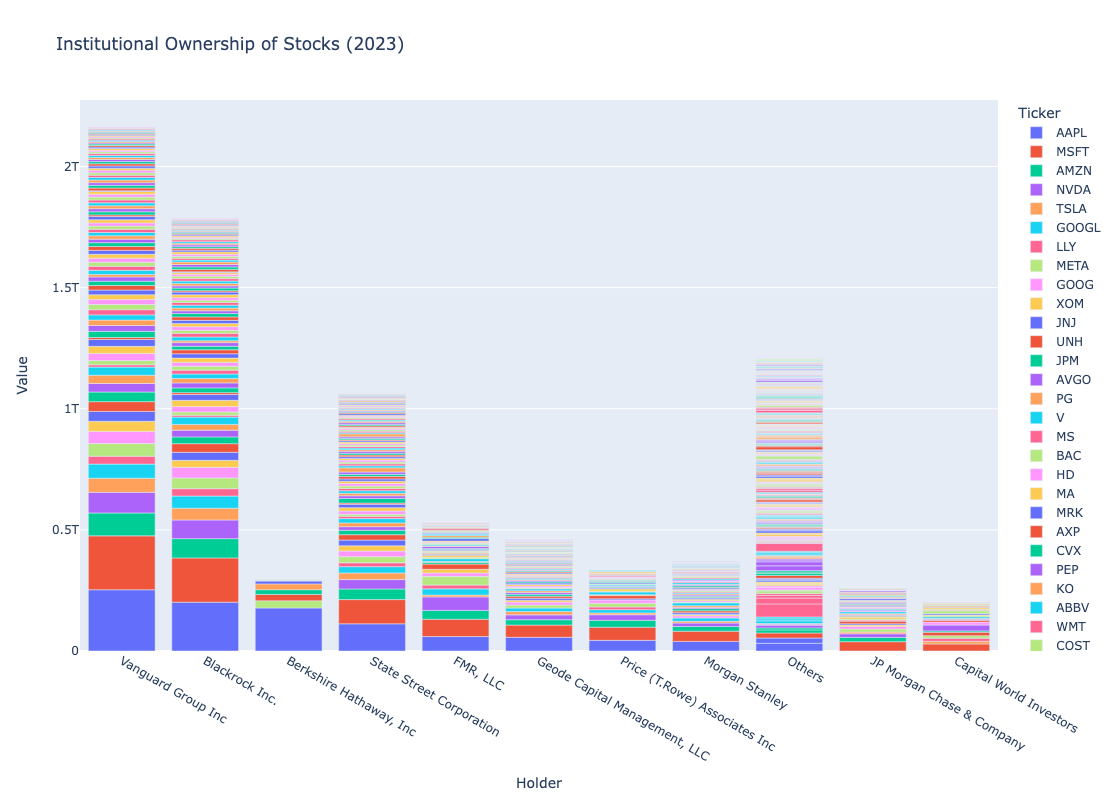

In [400]:
stk_ownd_all.sort_values(by = 'Value', ascending = False, inplace = True)

# plot the bar chart
fig = px.bar(stk_ownd_all, x="Holder", y="Value", color="Ticker", title="Institutional Ownership of Stocks (2023)",width=1100, height=800 )
fig.show()

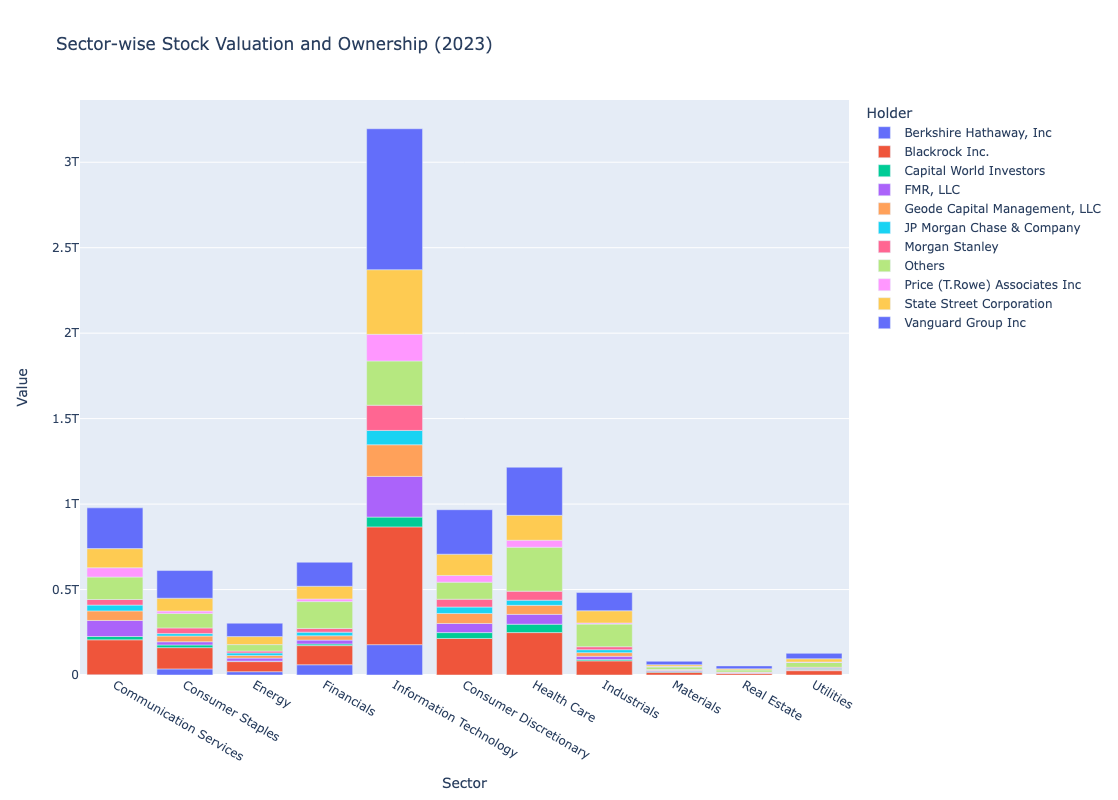

In [399]:
# get the breakdown by sector 
stk_ownd_all = stk_ownd_all.merge(df, left_on = 'Ticker', right_on = 'Symbol')
stk_ownd_all.drop('Symbol', axis = 'columns', inplace = True)
stk_by_sctr = stk_ownd_all.groupby(['Sector','Holder'])['Value'].agg('sum').reset_index()

# plot the bar chart
fig = px.bar(stk_by_sctr, x="Sector", y="Value", color="Holder", title="Sector-wise Stock Valuation and Ownership (2023)",width=1150, height=800 )
fig.show()